# Entrenamiento de modelos y selección de modelo

## Importación de datos y librerías

In [5]:
import os
from imutils import paths

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

from tensorflow.data import AUTOTUNE

import dagshub
import mlflow
from mlflow.models import infer_signature

dagshub.init("Proyecto-de-Ciencia-de-Datos", "judith-ale", mlflow=True)

Repository initialized!

Se crea un diccionario que transforma la letra en su id correspondiente.

In [6]:
dictLetras = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7,
    'i': 8,
    'l': 9,
    'm': 10,
    'n': 11,
    'o': 12,
    'p': 13,
    'r': 14,
    's': 15,
    't': 16,
    'u': 17,
    'v': 18,
    'w': 19,
    'y': 20
    }

## Data pipeline

Se crea un pipeline para manejar las imágenes en lotes.

Primero se crea una lista por cada dataset (`train`, `validation` y `test`) donde cada item es un string de 2 valores separados por comas, el primero siendo el path de la imagen y el segundo el id de la letra que está haciendo la mano en la imagen.

In [7]:
def reorganizar(path):
  return ','.join([path, str(dictLetras[path.split(os.path.sep)[-2]])])

In [8]:
train_data = list(map(reorganizar, list(
    paths.list_images('../Data/Clean Data/train'))))

test_data = list(map(reorganizar, list(
    paths.list_images('../Data/Clean Data/test'))))

val_data = list(map(reorganizar, list(
    paths.list_images('../Data/Clean Data/validation'))))

Para poder obtener cada imagen y etiqueta de su respectivo string se crea una función donde se separa dicho string por la coma, a continuación se lee el archivo correspondiente a la imagen, se decodifica como imagen `jpeg`, se convierte el arreglo (la imagen) a números flotantes y se cambia el tamaño a uno compatible con el algoritmo (en este caso 200x200).

Para la etiqueta se transforma el string a un entero de 32 bits.

Por último retorna la imagen y la etiqueta.

In [9]:
def load_image(data_entry):
  item= tf.strings.split(data_entry, sep=",")
  img = tf.io.read_file(item[0])
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, dtype=tf.float16)
  img = tf.image.resize(img, (200, 200))

  label = tf.cast(tf.strings.to_number(item[1]), dtype=tf.int32)

  return img, label

Con el listado de strings y la función anterior se construyen los pipelines para entrenamiento, validación y pruebas.

Primero se crea un iterador del listado para el cual se mezclaran de forma aleatoria las imágenes, en cada item de la lista hará la función anterior, almacenara los datos en cache, obtendrá por cada lote cierta cantidad de imágenes y hará la obtención de cada lote en un tiempo dinámico para tenerlo listo antes de que termine con el lote anterior.

Para entrenamiento y validación el tamaño del lote tiene que ser el mismo ya que por cada arreglo (imagen) en el entrenamiento del modelo debe haber uno correspondiente en la validación. En este caso se eligió de 32 imágenes.

Para el caso de pruebas este no tiene la restricción pasada por lo que se elige de la cantidad de imágenes totales en este lote para obtenerlas de forma fácil para su posterior análisis.

In [10]:
# Construcción de los pipelines para los datasets: training, validation, testing

batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = (train_dataset
                 .shuffle(len(train_data))
                 .map(load_image, num_parallel_calls=AUTOTUNE)
                 .cache()
                 .batch(batch_size)
                 .prefetch(AUTOTUNE)
                 )

val_dataset = tf.data.Dataset.from_tensor_slices(val_data)
val_dataset = (val_dataset
                 .shuffle(len(val_data))
                 .map(load_image, num_parallel_calls=AUTOTUNE)
                 .cache()
                 .batch(batch_size)
                 .prefetch(AUTOTUNE)
                 )

test_dataset = tf.data.Dataset.from_tensor_slices(test_data)
test_dataset = (test_dataset
                 .shuffle(len(test_data))
                 .map(load_image, num_parallel_calls=AUTOTUNE)
                 .cache()
                 .batch(630)
                 .prefetch(AUTOTUNE)
                 )

Se obtiene el lote (`batch`) de pruebas.

In [11]:
for batch in test_dataset:
  pass

## Modelo 1 (`InceptionV3_model`)

### Diseño

En el primer modelo se pone como una de sus capas un modelo pre-entrenado con la arquitectura de `InceptionV3` y los pesos de `imagenet` (que no son entrenables ya que se tiene como objetivo usar en su totalidad el modelo pre-entrenado), pero no se toma en cuenta la capa final ya que se usará con otro propósito, por lo que se une a otras capas de un diseño propio para obtener al final las 21 categorías por medio de una función `softmax` que da como resultado un vector de 21 valores donde cada valor es la probabilidad de que la imagen pertenezca a esa categoría, y la suma de este vector da 1.

In [12]:
input_shape = (200, 200, 3)

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

base_model.trainable = False

x = Conv2D(64, (3, 3), activation='relu')(base_model.output)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(21, activation='softmax')(x)


model1 = Model(inputs=base_model.input, outputs=output_layer)

model1.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 99, 99, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 99, 99, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

Como función de pérdida se usa el `Sparse categorical crossentropy` que a diferencia del `Categorical crossentropy` en la que se debe hacer codificación `One Hot` permite que la variable objetivo verdadera sea un solo valor numérico que represente la categoría.

In [13]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Entrenamiento

Para el entrenamiento se creó un experimento de `mlflow` donde se va a registrar el modelo, las métricas, el nombre del modelo y como deben estar estructurados los datos de entrada y salida.

El modelo se entrenará con 10 épocas.

In [15]:
experiment_name = "InceptionV3_model"
experiment_id = mlflow.create_experiment(experiment_name)
print("Experiment ID:", experiment_id)

mlflow.tensorflow.autolog()
with mlflow.start_run(experiment_id=experiment_id, run_name=experiment_name) as run:
  epochs = 10
  history = model1.fit(
      train_dataset,
      epochs=epochs,
      validation_data=val_dataset
      )


  predictions = model1.predict(batch[0].numpy())

  signature = infer_signature(batch[0].numpy(), predictions)

  mlflow.sklearn.log_model(model1, experiment_name, signature=signature)

Experiment ID: 2
Epoch 1/10
138/138 [==============================] - 30s 101ms/step - loss: 0.9664 - accuracy: 0.7229 - val_loss: 0.1939 - val_accuracy: 0.9444
Epoch 2/10
138/138 [==============================] - 11s 80ms/step - loss: 0.1122 - accuracy: 0.9642 - val_loss: 0.1472 - val_accuracy: 0.9524
Epoch 3/10
138/138 [==============================] - 11s 79ms/step - loss: 0.0555 - accuracy: 0.9841 - val_loss: 0.0777 - val_accuracy: 0.9738
Epoch 4/10
138/138 [==============================] - 11s 82ms/step - loss: 0.0183 - accuracy: 0.9955 - val_loss: 0.0452 - val_accuracy: 0.9873
Epoch 5/10
138/138 [==============================] - 11s 81ms/step - loss: 0.0049 - accuracy: 0.9998 - val_loss: 0.0464 - val_accuracy: 0.9849
Epoch 6/10
138/138 [==============================] - 11s 81ms/step - loss: 0.0027 - accuracy: 0.9998 - val_loss: 0.0330 - val_accuracy: 0.9905
Epoch 7/10
138/138 [==============================] - 11s 82ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.02

2023/11/23 06:09:24 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpfqizfc13/model, flavor: tensorflow), fall back to return ['tensorflow==2.14.0']. Set logging level to DEBUG to see the full traceback.
2023/11/23 06:09:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


20/20 [==============================] - 2s 114ms/step


2023/11/23 06:10:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp1zsptz8f/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


### Prueba

El `accuracy en la prueba es de 98.8% donde se equivocó en 7 imágenes de las 630 y nunca más de una vez por categoría.

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

20/20 [==============================] - 1s 64ms/step - loss: 0.0319 - accuracy: 0.9889
Test accuracy: 0.9888888597488403


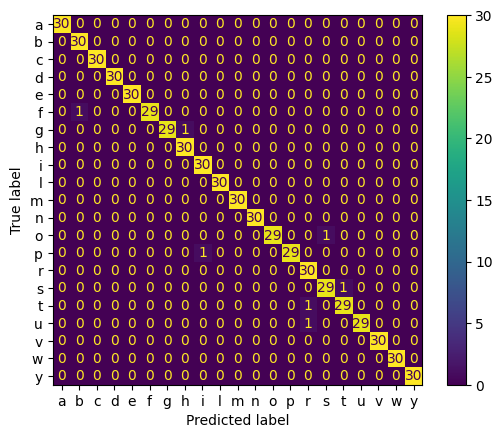

In [23]:
test_loss, test_accuracy = model1.evaluate(*batch)
print(f'Test accuracy: {test_accuracy}')
cm = confusion_matrix(batch[1], predictions.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dictLetras.keys())
_ = disp.plot()

## Modelo 2 (`new_created_model`)

### Diseño

En el segundo modelo únicamente es un diseño propio de una red neuronal convolucional para obtener al final las 21 categorías por medio de la función `softmax` que como se especificó en el modelo anterior da como resultado un vector de 21 valores donde cada valor es la probabilidad de que la imagen pertenezca a esa categoría, y la suma de este vector da 1.

In [24]:
input_shape = (200, 200, 3)

input_layer = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(21, activation='softmax')(x)

model2 = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_95 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 147456)            0   

Como función de pérdida se usa el `Sparse categorical crossentropy` que a diferencia del `Categorical crossentropy` en la que se debe hacer codificación `One Hot` permite que la variable objetivo verdadera sea un solo valor numérico que represente la categoría.

In [26]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Entrenamiento

Para el entrenamiento se creó un experimento de `mlflow` donde se va a registrar el modelo, las métricas, el nombre del modelo y como deben estar estructurados los datos de entrada y salida.

El modelo se entrenará con 20 épocas.

In [27]:
experiment_name = "new_created_model"
experiment_id = mlflow.create_experiment(experiment_name)
print("Experiment ID:", experiment_id)

mlflow.tensorflow.autolog()
with mlflow.start_run(experiment_id=experiment_id, run_name=experiment_name) as run:
  epochs = 20
  history = model2.fit(
      train_dataset,
      epochs=epochs,
      validation_data=val_dataset
      )


  predictions = model2.predict(batch[0].numpy())

  signature = infer_signature(batch[0].numpy(), predictions)

  mlflow.sklearn.log_model(model2, experiment_name, signature=signature)

Experiment ID: 4
Epoch 1/20
  5/138 [>.............................] - ETA: 5s - loss: 3.8548 - accuracy: 0.0437

138/138 [==============================] - 10s 52ms/step - loss: 2.5400 - accuracy: 0.2392 - val_loss: 1.7264 - val_accuracy: 0.4929
Epoch 2/20
138/138 [==============================] - 7s 54ms/step - loss: 1.2038 - accuracy: 0.6220 - val_loss: 1.0643 - val_accuracy: 0.6690
Epoch 3/20
138/138 [==============================] - 7s 48ms/step - loss: 0.6921 - accuracy: 0.7719 - val_loss: 0.7562 - val_accuracy: 0.7754
Epoch 4/20
138/138 [==============================] - 7s 52ms/step - loss: 0.4700 - accuracy: 0.8454 - val_loss: 0.5273 - val_accuracy: 0.8476
Epoch 5/20
138/138 [==============================] - 7s 52ms/step - loss: 0.3333 - accuracy: 0.8873 - val_loss: 0.4506 - val_accuracy: 0.8579
Epoch 6/20
138/138 [==============================] - 6s 46ms/step - loss: 0.2638 - accuracy: 0.9093 - val_loss: 0.5095 - val_accuracy: 0.8357
Epoch 7/20
138/138 [==============================] - 7s 48ms/step - loss: 0.1804 - accuracy: 0.9356 - val_loss: 0.3925 - val_accuracy: 0.8810
Epoch 8/2

2023/11/23 06:29:42 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.20+cuda11.cudnn86) contains a local version label (+cuda11.cudnn86). MLflow logged a pip requirement for this package as 'jaxlib==0.4.20' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


### Prueba

El `accuracy` en la prueba es de 90.47% donde se equivocó en 50 imágenes de las 630, siendo las letra `s` la que tuvo menos predicciones correctas con un 20 de las 30 imágenes (66.6%).

20/20 [==============================] - 0s 17ms/step - loss: 0.3831 - accuracy: 0.9048
Test accuracy: 0.9047619104385376


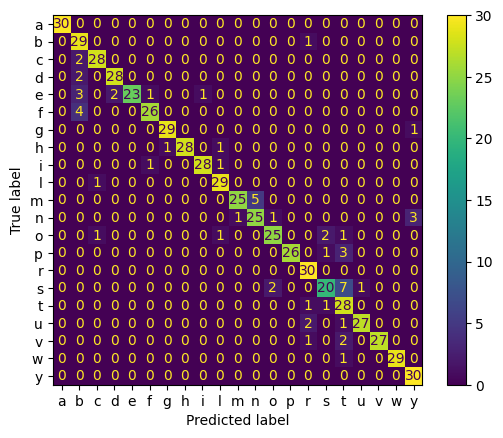

In [28]:
test_loss, test_accuracy = model2.evaluate(*batch)
print(f'Test accuracy: {test_accuracy}')
cm = confusion_matrix(batch[1], predictions.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dictLetras.keys())
_ = disp.plot()

## Selección del modelo

De acuerdo con las métricas de desempeño anteriormente revisadas, el modelo que se elegirá para continuar el proyecto es el modelo 1 (`InceptionV3_model`) que tuvo el mejor ajuste en entrenamiento y las mejores predicciones en pruebas.